# Predicting wave

El objetivo principal del trabajo es predecir el nivel de ingresos por hora de un individuo basándose en diversos atributos personales (edad, sexo, categoría ocupacional, horas trabajadas y nivel educativo máximo alcanzado).

Para ello nos basaremos en los datos empleados en este estudio se originan en la Gran Encuesta Integrada de Hogares (GEIH), un relevamiento llevado a cabo por el Departamento Administrativo Nacional de Estadística (DANE) de Colombia.

Para fines de este trabajo, necesitamos acceder a esta información mediante 10 bases de datos que contienen variables originales y otras reconstruidas, disponibles en la siguiente página web: https://ignaciomsarmiento.github.io/GEIH2018_sample/. Vamos a realizar dicho acceso empleando técnicas de web scraping.

### **Step 1. Web Scrapping**

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
#Definimos nuestra función para hacer el webscrapping
def scrape_table(url, include_headers=True):
    # Envía un HTTP request al URL
    response = requests.get(url)

    # Creamos un objeto para a BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Buscamos la tabla que queremos importar del HTML
    table = soup.find('table')

    # Inicializamos una lista para almacenar los datos importados
    data = []

    # Extraemos las filas de la tabla
    for i, row in enumerate(table.find_all('tr')):
        # Ahora los datos
        row_data = []
        for cell in row.find_all(['th', 'td']):
            row_data.append(cell.text.strip())

        # Agregamos encabezados condicionalmente solo para la primera URL.
        #Esto es para que no se nos importe el nombre de las variables cada vez
        #que importamos las bases.
        if i == 0 and include_headers:
            headers = row_data
        else:
            data.append(row_data)

    # Creamos un marco de datos de Pandas
    if include_headers:
        df = pd.DataFrame(data, columns=headers)
    else:
        df = pd.DataFrame(data)

    return df

In [4]:
# Creamos una lista con los 10 URL en los cuales vamos a iterar
urls = ['https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_1.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_2.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_3.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_4.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_5.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_6.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_7.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_8.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_9.html',
        'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_10.html',
        ]

In [5]:
# Creamos un DataFrame vacío para almacenar los resultados
final_df = pd.DataFrame()

In [6]:
# Scrapeamos los URL y concatenamos los resultados
for url in urls:
    df = scrape_table(url)
    final_df = pd.concat([final_df, df], ignore_index=True)

In [7]:
final_df.head()

,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
0,1,4514331,1,2,1,BOGOTA,1,2,0,29,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NA,NA,NA,8404.3203125,NA,NA,NA,NA,1620833.25,8404.3203125
2,3,4514332,1,4,1,BOGOTA,1,2,1,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4,4514332,1,3,1,BOGOTA,1,2,1,7,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5,4514332,1,1,1,BOGOTA,1,2,0,32,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
# Mostrar el número de observaciones en el DF por control
num_observaciones = final_df.shape[0]
print("Número de observaciones:", num_observaciones)

Número de observaciones: 32177


### **Step 2. Trabajo de limpieza de datos**


In [9]:
#Primero hacemos una copia por seguridad
df_copia = final_df.copy()

In [10]:
#Eliminamos observaciones sin datos
import numpy as np
# Reemplazar "NA" con NaN en la columna 'y_salary_m_hu' que es la de salario horario
df_copia['y_salary_m_hu'] = df_copia['y_salary_m_hu'].replace("NA", np.nan)
# Convertir la columna 'y_salary_m_hu' a tipo numérico
df_copia['y_salary_m_hu'] = pd.to_numeric(df_copia['y_salary_m_hu'], errors='coerce')
# Eliminar filas con NaN en la columna 'y_salary_m_hu'
df_copia = df_copia.dropna(subset=['y_salary_m_hu'])

In [11]:
#Elimiar individuos menores de 18 años
#Convertimos a numérica
df_copia['age'] = pd.to_numeric(df_copia['age'], errors='coerce')
# Aplicamos filtro
df_copia = df_copia[df_copia['age'] > 18]

In [12]:
#Eliminamos observaciones con ingresos cero o sin datos
df_copia['y_salary_m_hu'] = pd.to_numeric(df_copia['y_salary_m_hu'], errors='coerce')
df_copia = df_copia[df_copia['y_salary_m_hu'] > 0]

In [13]:
#Convertimos a logaritmo la variable de ingreso
df_copia['ingresos_log'] = np.log(df_copia['y_salary_m_hu'])

In [16]:
# Mostrar el número de observaciones en el DF por control
num_observaciones = df_copia.shape[0]
print("Número de observaciones:", num_observaciones)

Número de observaciones: 9785


### **Step 3. Análisis descriptivos**



In [17]:
## Estadísticos básicos de la variable ingresos
descripcion = df_copia['y_salary_m_hu'].describe()
print(descripcion)

count      9785.000000
mean       7984.262071
std       11629.426704
min         151.909729
25%        3797.704102
50%        4520.833496
75%        7291.666504
max      291666.656250
Name: y_salary_m_hu, dtype: float64


In [18]:
## Media de edad de la muestra
media_edad = df_copia['age'].mean()

# Imprime la media de la edad
print(f"La media de la edad es: {media_edad:.2f}")

La media de la edad es: 36.44


In [19]:
## % hombres en la muestra

# Convertir la columna 'sex' a tipo numérico
df_copia['sex'] = pd.to_numeric(df_copia['sex'], errors='coerce')

total_hombres = df_copia['sex'].sum()
total_muestra = len(df_copia['sex'])

if total_muestra == 0:
    print("No hay datos en la muestra.")
else:
    porcentaje_hombres = (total_hombres / total_muestra) * 100
    print(f"Porcentaje de hombres en la muestra: {porcentaje_hombres:.2f}%")


Porcentaje de hombres en la muestra: 50.18%


In [20]:
## % ocupados formales en la muestra

# Convertir la columna 'formal' a tipo numérico
df_copia['formal'] = pd.to_numeric(df_copia['formal'], errors='coerce')

total_ocupados = df_copia['formal'].sum()
total_muestra_ocupados = len(df_copia['formal'])

if total_muestra_ocupados == 0:
    print("No hay datos en la muestra.")
else:
    porcentaje_ocupados = (total_ocupados / total_muestra) * 100
    print(f"Porcentaje de ocupados formales en la muestra: {porcentaje_ocupados:.2f}%")


Porcentaje de ocupados formales en la muestra: 77.28%


In [21]:
categorias_p6210 = df_copia['p6210'].unique()

# Imprime las categorías únicas
print(categorias_p6210)

['5' '6' '3' '4' '1' '9']


In [22]:
df_copia['educ_none'] = (df_copia['p6210'].astype(str).str.strip() == '1').astype(int)
df_copia['educ_primary'] = (df_copia['p6210'].astype(str).str.strip() == '3').astype(int)
df_copia['educ_secundary'] = (df_copia['p6210'].astype(str).str.strip() == '4').astype(int)
df_copia['educ_media'] = (df_copia['p6210'].astype(str).str.strip() == '5').astype(int)
df_copia['educ_univ'] = (df_copia['p6210'].astype(str).str.strip() == '6').astype(int)
df_copia['educ_nodata'] = (df_copia['p6210'].astype(str).str.strip() == '9').astype(int)

In [24]:
df_copia['hoursWorkUsual'] = pd.to_numeric(df_copia['hoursWorkUsual'], errors='coerce')
horas_trabajadas = df_copia['hoursWorkUsual'].describe()
print(horas_trabajadas)

count    9785.000000
mean       48.081451
std        12.061771
min         1.000000
25%        48.000000
50%        48.000000
75%        48.000000
max       130.000000
Name: hoursWorkUsual, dtype: float64


### **Step 4. Tareas de predicción**


**4.1 Primeras predicciones en muestra**

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
from statsmodels.formula.api import ols

In [26]:
#Creamos nueva variable para la edad
df_copia['age2'] = df_copia['age'] ** 2

In [27]:
#Hacemos regresión lineal tradicional
reg_statsmodels = ols("ingresos_log~age+age2+sex+formal+hoursWorkUsual+educ_primary+educ_secundary+educ_media+educ_univ+educ_nodata", data = df_copia).fit()
print(reg_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:           ingresos_log   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     637.8
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:19:09   Log-Likelihood:                -8225.7
No. Observations:                9785   AIC:                         1.647e+04
Df Residuals:                    9774   BIC:                         1.655e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.0174      0.102     69.

**4.2 Predicciones fuera de muestra**

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [38]:
X = df_copia[[ "age", "age2", "sex", "formal", "hoursWorkUsual", "educ_primary", "educ_secundary", "educ_media", "educ_univ", "educ_nodata",]]

Y = df_copia[["ingresos_log"]]

In [39]:
X.describe()

,age,age2,sex,formal,hoursWorkUsual,educ_primary,educ_secundary,educ_media,educ_univ,educ_nodata
count,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000,9785.000000
mean,36.438324,1470.225958,0.501788,0.772816,48.081451,0.103117,0.094124,0.343996,0.454062,0.000102
std,11.936878,969.935752,0.500022,0.419034,12.061771,0.304127,0.292016,0.475064,0.497911,0.010109
min,19.000000,361.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,729.000000,0.000000,1.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,1156.000000,1.000000,1.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,2025.000000,1.000000,1.000000,48.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,86.000000,7396.000000,1.000000,1.000000,130.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
#Particionamos la muestra: una de entrenamiento y otra de testeo
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        Y,
                                        test_size=0.3,
                                        train_size=0.7,
                                        random_state = 123
                                    )

In [41]:
X_train.head()

,age,age2,sex,formal,hoursWorkUsual,educ_primary,educ_secundary,educ_media,educ_univ,educ_nodata
7741,43,1849,1,1,48,0,0,1,0,0
22475,32,1024,1,1,72,0,0,0,1,0
13596,19,361,0,0,30,0,0,0,1,0
31707,29,841,0,1,48,0,0,1,0,0
15334,19,361,1,0,48,0,0,1,0,0


In [42]:
#Modelo 1 en base a solo constante
X0 = np.ones((len(y_train), 1))
model1=  LinearRegression().fit(X0,y_train)
model1.intercept_

array([8.63182063])

In [43]:
y_train.mean()

ingresos_log    8.631821
dtype: float64

In [44]:
#Predecimos en la nueva data
X0_test = np.ones((len(y_test), 1))
y_hat_model1 = model1.predict(X0_test)

In [45]:
from sklearn.metrics import mean_squared_error

# Calculamos MSE
mse1 = mean_squared_error(y_test, y_hat_model1)

print(f'Mean Squared Error: {mse1}')

Mean Squared Error: 0.5244232709631309


In [46]:
#Creamos Modelo 2 con dos covariables y replicamos mismos pasos que antes
model2=  LinearRegression().fit(X_train[['age', 'age2']],y_train)
model2.coef_

array([[ 0.05857337, -0.00063439]])

In [47]:
y_hat_model2 = model2.predict(X_test[['age', 'age2']])

In [48]:
mse2 = mean_squared_error(y_test, y_hat_model2)

print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 0.5070420847452832


In [49]:
#Creamos Modelo 3 y replicamos mismos pasos que antes

model3=  LinearRegression().fit(X_train[['age', "age2", "hoursWorkUsual"]],y_train)
model3.coef_

array([[ 0.06560475, -0.00073031, -0.01240606]])

In [50]:
y_hat_model3 = model3.predict(X_test[['age', "age2", "hoursWorkUsual"]])

In [51]:
mse3 = mean_squared_error(y_test, y_hat_model3)

print(f'Mean Squared Error: {mse3}')

Mean Squared Error: 0.47848854348284486


In [52]:
#Creamos Modelo 4 y replicamos mismos pasos que antes

model4=  LinearRegression().fit(X_train[['age', "age2", "sex", "hoursWorkUsual"]],y_train)
model4.coef_

array([[ 0.0671168 , -0.00074849,  0.10916378, -0.01324467]])

In [53]:
y_hat_model4 = model4.predict(X_test[['age', "age2", "sex", "hoursWorkUsual"]])

In [54]:
mse4 = mean_squared_error(y_test, y_hat_model4)

print(f'Mean Squared Error: {mse4}')

Mean Squared Error: 0.4737798508068708


In [55]:
#Creamos Modelo 5 y replicamos mismos pasos que antes

model5=  LinearRegression().fit(X_train[['age', "age2", "sex", "formal", "hoursWorkUsual"]],y_train)
model5.coef_

array([[ 4.80570445e-02, -5.18217678e-04,  9.47066500e-02,
         5.95693003e-01, -1.45266382e-02]])

In [56]:
y_hat_model5 = model5.predict(X_test[['age', "age2", "sex", "formal", "hoursWorkUsual"]])

In [57]:
mse5 = mean_squared_error(y_test, y_hat_model5)

print(f'Mean Squared Error: {mse5}')

Mean Squared Error: 0.41125674981824334


In [58]:
#Creamos Modelo 6 y replicamos mismos pasos que antes

model6=  LinearRegression().fit(X_train[["age", "age2", "sex", "formal", "educ_primary", "educ_secundary", "educ_media", "educ_univ", "educ_nodata", "hoursWorkUsual"]],y_train)
model6.coef_


array([[ 5.15602333e-02, -4.83805047e-04,  1.58661482e-01,
         3.67264696e-01,  2.51766551e-01,  2.98979999e-01,
         4.18321542e-01,  1.03411224e+00,  6.03177025e-02,
        -1.06810091e-02]])

In [59]:
y_hat_model6 = model6.predict(X_test[["age", "age2", "sex", "formal", "educ_primary", "educ_secundary", "educ_media", "educ_univ", "educ_nodata", "hoursWorkUsual"]])
mse6 = mean_squared_error(y_test, y_hat_model6)

print(f'Mean Squared Error: {mse6}')

Mean Squared Error: 0.3106732062084532


In [60]:
from sklearn.preprocessing import PolynomialFeatures

?PolynomialFeatures

In [61]:
#Ahora creamos los 4 modelos restantes pero con mayor complejidad generando distintas combinaciones polinómicas
##Creamos Modelo 7 con combinaciones polinómicas de grado 2
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train)
model7 =  LinearRegression().fit(X_train_poly2,y_train)

In [62]:
X_test_poly2 = poly2.fit_transform(X_test)
y_hat_model7 = model7.predict(X_test_poly2)
mse7 = mean_squared_error(y_test, y_hat_model7)
print(f'Mean Squared Error: {mse7}')

Mean Squared Error: 0.2767254262608403


In [63]:
#Ver cantidad de covariables usadas en el Modelo
feature_names = poly2.get_feature_names_out()
print("Nombres de características:", feature_names)
print("Número total de variables:", len(feature_names))

Nombres de características: ['1' 'age' 'age2' 'sex' 'formal' 'hoursWorkUsual' 'educ_primary'
 'educ_secundary' 'educ_media' 'educ_univ' 'educ_nodata' 'age^2'
 'age age2' 'age sex' 'age formal' 'age hoursWorkUsual' 'age educ_primary'
 'age educ_secundary' 'age educ_media' 'age educ_univ' 'age educ_nodata'
 'age2^2' 'age2 sex' 'age2 formal' 'age2 hoursWorkUsual'
 'age2 educ_primary' 'age2 educ_secundary' 'age2 educ_media'
 'age2 educ_univ' 'age2 educ_nodata' 'sex^2' 'sex formal'
 'sex hoursWorkUsual' 'sex educ_primary' 'sex educ_secundary'
 'sex educ_media' 'sex educ_univ' 'sex educ_nodata' 'formal^2'
 'formal hoursWorkUsual' 'formal educ_primary' 'formal educ_secundary'
 'formal educ_media' 'formal educ_univ' 'formal educ_nodata'
 'hoursWorkUsual^2' 'hoursWorkUsual educ_primary'
 'hoursWorkUsual educ_secundary' 'hoursWorkUsual educ_media'
 'hoursWorkUsual educ_univ' 'hoursWorkUsual educ_nodata' 'educ_primary^2'
 'educ_primary educ_secundary' 'educ_primary educ_media'
 'educ_primary educ

In [64]:
##Creamos Modelo 8 con combinaciones polinómicas de grado 4
poly4 = PolynomialFeatures(degree=4)
X_train_poly4 = poly4.fit_transform(X_train)
model8 =  LinearRegression().fit(X_train_poly4,y_train)

In [65]:
X_test_poly4 = poly4.fit_transform(X_test)
y_hat_model8 = model8.predict(X_test_poly4)
mse8 = mean_squared_error(y_test, y_hat_model8)
print(f'Mean Squared Error: {mse8}')

Mean Squared Error: 0.6834307830978328


In [66]:
feature_names = poly4.get_feature_names_out()
print("Nombres de características:", feature_names)
print("Número total de variables:", len(feature_names))

Nombres de características: ['1' 'age' 'age2' ... 'educ_univ^2 educ_nodata^2'
 'educ_univ educ_nodata^3' 'educ_nodata^4']
Número total de variables: 1001


In [67]:
##Creamos Modelo 9 con combinaciones polinómicas de grado 5
poly5 = PolynomialFeatures(degree=5)
X_train_poly5 = poly5.fit_transform(X_train)
model9 =  LinearRegression().fit(X_train_poly5,y_train)

In [68]:
X_test_poly5 = poly5.fit_transform(X_test)
y_hat_model9 = model9.predict(X_test_poly5)
mse9 = mean_squared_error(y_test, y_hat_model9)
print(f'Mean Squared Error: {mse9}')

Mean Squared Error: 3.9691838992554853


In [69]:
feature_names = poly5.get_feature_names_out()
print("Nombres de características:", feature_names)
print("Número total de variables:", len(feature_names))

Nombres de características: ['1' 'age' 'age2' ... 'educ_univ^2 educ_nodata^3'
 'educ_univ educ_nodata^4' 'educ_nodata^5']
Número total de variables: 3003


In [70]:
##Creamos Modelo 10 con combinaciones polinómicas de grado 6
poly6 = PolynomialFeatures(degree=6)
X_train_poly6 = poly6.fit_transform(X_train)
model10 =  LinearRegression().fit(X_train_poly6,y_train)

In [71]:
X_test_poly6 = poly6.fit_transform(X_test)
y_hat_model10 = model10.predict(X_test_poly6)
mse10 = mean_squared_error(y_test, y_hat_model10)
print(f'Mean Squared Error: {mse10}')

Mean Squared Error: 20.34603529849248


In [72]:
feature_names = poly6.get_feature_names_out()
print("Nombres de características:", feature_names)
print("Número total de variables:", len(feature_names))

Nombres de características: ['1' 'age' 'age2' ... 'educ_univ^2 educ_nodata^4'
 'educ_univ educ_nodata^5' 'educ_nodata^6']
Número total de variables: 8008


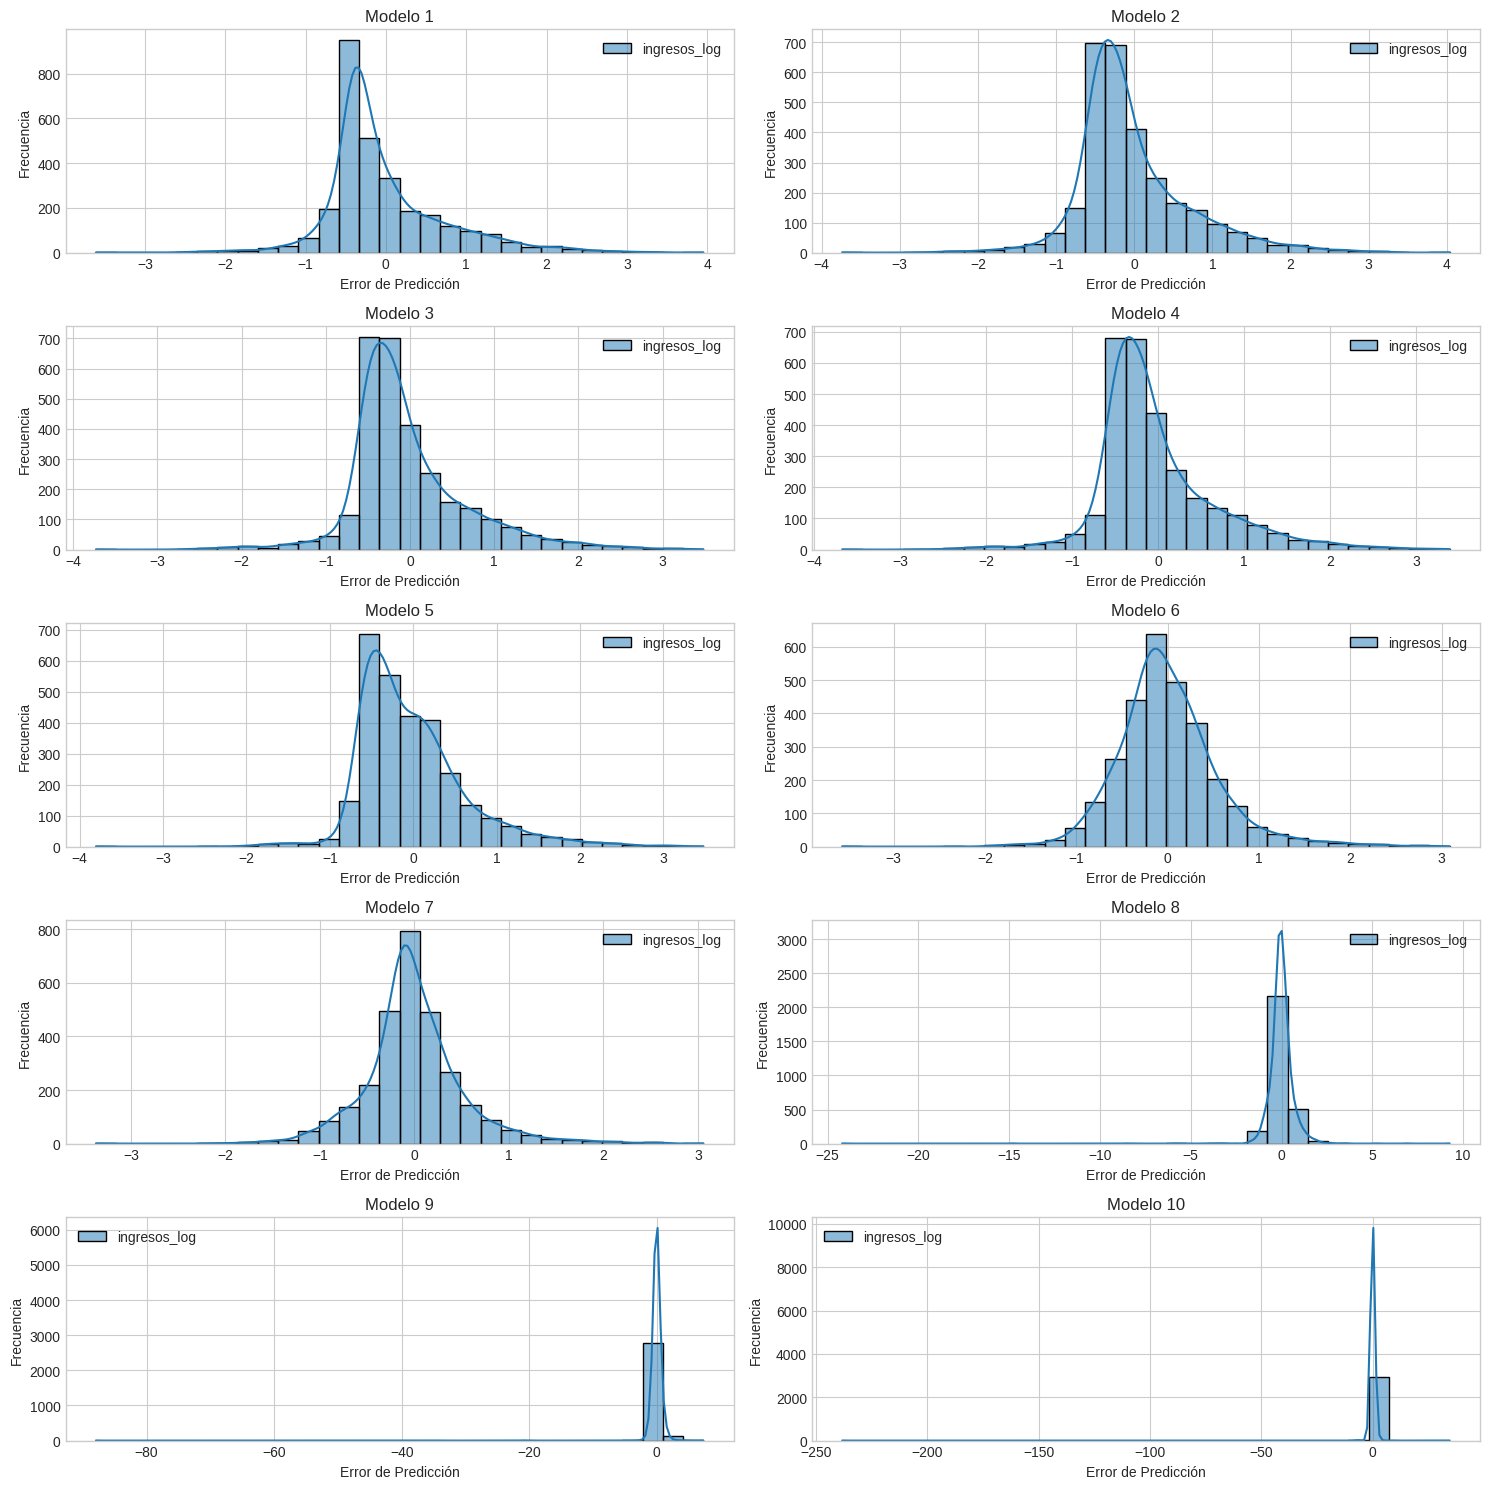

In [73]:
#Para graficar las distribuciones de los errores predictivos por fuera de muestra
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de errores para cada modelo
errors_list = [y_test - y_hat_model1, y_test - y_hat_model2, y_test - y_hat_model3,
               y_test - y_hat_model4, y_test - y_hat_model5, y_test - y_hat_model6,
               y_test - y_hat_model7, y_test - y_hat_model8, y_test - y_hat_model9,
               y_test - y_hat_model10]

# Configuración de la cuadrícula de subgráficos
rows = 5  # Número de filas en la cuadrícula
cols = 2  # Número de columnas en la cuadrícula

# Crear la cuadrícula de subgráficos
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Aplanar el arreglo de subgráficos para facilitar el acceso
axes = axes.flatten()

# Iterar sobre cada modelo y crear un histograma en su subgráfico correspondiente
for i, errors in enumerate(errors_list):
    sns.histplot(errors, bins=30, kde=True, ax=axes[i], color='C'+str(i))
    axes[i].set_title(f'Modelo {i+1}')
    axes[i].set_xlabel('Error de Predicción')
    axes[i].set_ylabel('Frecuencia')

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [74]:
#Calculamos el error nuecamente para los modelos con menor MSE pero ahora con técnica LOOCV
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np

poly7 = PolynomialFeatures(degree=2)
X_train_poly7 = poly7.fit_transform(X_train)

poly8 = PolynomialFeatures(degree=4)
X_train_poly8 = poly8.fit_transform(X_train)

# Crear generador LOOCV
loo = LeaveOneOut()

# Calcular error predictivo para el Modelo 7
mse_model7 = cross_val_score(model7, X_train_poly7, y_train, scoring='neg_mean_squared_error', cv=loo)
mean_mse_model7 = np.mean(-mse_model7)

# Calcular error predictivo para el Modelo 8
mse_model8 = cross_val_score(model8, X_train_poly8, y_train, scoring='neg_mean_squared_error', cv=loo)
mean_mse_model8 = np.mean(-mse_model8)

print(f'Mean Squared Error (LOOCV) for Model 7: {mean_mse_model7}')
print(f'Mean Squared Error (LOOCV) for Model 8: {mean_mse_model8}')


Mean Squared Error (LOOCV) for Model 7: 0.28508081073106245
Mean Squared Error (LOOCV) for Model 8: 1.6401728445824997
